In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath('thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
from thinker.buffer import ModelBuffer
import thinker.util as util
import gym
import gym_csokoban

def plot_gym_env_out(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(torch.swapaxes(torch.swapaxes(x[0].cpu(),0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)

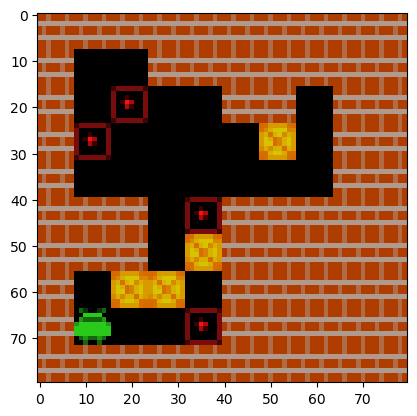

In [2]:
flags = util.parse([])
env = gym.make(flags.env)
obs = env.reset()
fig, ax = plt.subplots()
ax.imshow(obs)

In [2]:
import gym
from gym.spaces import Tuple
from gym.vector.utils.spaces import batch_space

__all__ = ["VectorEnv"]

class VectorEnv(gym.Env):
    r"""Base class for vectorized environments.

    Each observation returned from vectorized environment is a batch of observations
    for each sub-environment. And :meth:`step` is also expected to receive a batch of
    actions for each sub-environment.

    .. note::

        All sub-environments should share the identical observation and action spaces.
        In other words, a vector of multiple different environments is not supported.

    Parameters
    ----------
    num_envs : int
        Number of environments in the vectorized environment.

    observation_space : `gym.spaces.Space` instance
        Observation space of a single environment.

    action_space : `gym.spaces.Space` instance
        Action space of a single environment.
    """

    def __init__(self, num_envs, observation_space, action_space):
        super(VectorEnv, self).__init__()
        self.num_envs = num_envs
        self.is_vector_env = True
        self.observation_space = batch_space(observation_space, n=num_envs)
        self.action_space = Tuple((action_space,) * num_envs)

        self.closed = False
        self.viewer = None

        # The observation and action spaces of a single environment are
        # kept in separate properties
        self.single_observation_space = observation_space
        self.single_action_space = action_space

    def reset_async(self):
        pass

    def reset_wait(self, **kwargs):
        raise NotImplementedError()

    def reset(self):
        r"""Reset all sub-environments and return a batch of initial observations.

        Returns
        -------
        observations : sample from `observation_space`
            A batch of observations from the vectorized environment.
        """
        self.reset_async()
        return self.reset_wait()

    def step_async(self, actions):
        pass

    def step_wait(self, **kwargs):
        raise NotImplementedError()

    def step(self, actions, inds=None):
        r"""Take an action for each sub-environments.

        Parameters
        ----------
        actions : iterable of samples from `action_space`
            List of actions.

        Returns
        -------
        observations : sample from `observation_space`
            A batch of observations from the vectorized environment.

        rewards : `np.ndarray` instance (dtype `np.float_`)
            A vector of rewards from the vectorized environment.

        dones : `np.ndarray` instance (dtype `np.bool_`)
            A vector whose entries indicate whether the episode has ended.

        infos : list of dict
            A list of auxiliary diagnostic information dicts from sub-environments.
        """

        self.step_async(actions, inds)
        return self.step_wait()

    def close_extras(self, **kwargs):
        r"""Clean up the extra resources e.g. beyond what's in this base class."""
        raise NotImplementedError()

    def close(self, **kwargs):
        r"""Close all sub-environments and release resources.

        It also closes all the existing image viewers, then calls :meth:`close_extras` and set
        :attr:`closed` as ``True``.

        .. warning::

            This function itself does not close the environments, it should be handled
            in :meth:`close_extras`. This is generic for both synchronous and asynchronous
            vectorized environments.

        .. note::

            This will be automatically called when garbage collected or program exited.

        """
        if self.closed:
            return
        if self.viewer is not None:
            self.viewer.close()
        self.close_extras(**kwargs)
        self.closed = True

    def seed(self, seeds=None):
        """
        Parameters
        ----------
        seeds : list of int, or int, optional
            Random seed for each individual environment. If `seeds` is a list of
            length `num_envs`, then the items of the list are chosen as random
            seeds. If `seeds` is an int, then each environment uses the random
            seed `seeds + n`, where `n` is the index of the environment (between
            `0` and `num_envs - 1`).
        """
        pass

    def __del__(self):
        if not getattr(self, "closed", True):
            self.close(terminate=True)

    def __repr__(self):
        if self.spec is None:
            return "{}({})".format(self.__class__.__name__, self.num_envs)
        else:
            return "{}({}, {})".format(
                self.__class__.__name__, self.spec.id, self.num_envs
            )


class VectorEnvWrapper(VectorEnv):
    r"""Wraps the vectorized environment to allow a modular transformation.

    This class is the base class for all wrappers for vectorized environments. The subclass
    could override some methods to change the behavior of the original vectorized environment
    without touching the original code.

    .. note::

        Don't forget to call ``super().__init__(env)`` if the subclass overrides :meth:`__init__`.

    """

    def __init__(self, env):
        assert isinstance(env, VectorEnv)
        self.env = env

    # explicitly forward the methods defined in VectorEnv
    # to self.env (instead of the base class)
    def reset_async(self):
        return self.env.reset_async()

    def reset_wait(self):
        return self.env.reset_wait()

    def step_async(self, actions):
        return self.env.step_async(actions)

    def step_wait(self):
        return self.env.step_wait()

    def close(self, **kwargs):
        return self.env.close(**kwargs)

    def close_extras(self, **kwargs):
        return self.env.close_extras(**kwargs)

    def seed(self, seeds=None):
        return self.env.seed(seeds)

    # implicitly forward all other methods and attributes to self.env
    def __getattr__(self, name):
        if name.startswith("_"):
            raise AttributeError(
                "attempted to get missing private attribute '{}'".format(name)
            )
        return getattr(self.env, name)

    @property
    def unwrapped(self):
        return self.env.unwrapped

    def __repr__(self):
        return "<{}, {}>".format(self.__class__.__name__, self.env)


In [5]:
import numpy as np
import multiprocessing as mp
import time
import sys
from enum import Enum
from copy import deepcopy

from gym import logger
#from gym.vector.vector_env import VectorEnv
from gym.error import (
    AlreadyPendingCallError,
    NoAsyncCallError,
    ClosedEnvironmentError,
    CustomSpaceError,
)
from gym.vector.utils import (
    create_shared_memory,
    create_empty_array,
    write_to_shared_memory,
    read_from_shared_memory,
    concatenate,
    CloudpickleWrapper,
    clear_mpi_env_vars,
)

__all__ = ["AsyncVectorEnv"]


class AsyncState(Enum):
    DEFAULT = "default"
    WAITING_RESET = "reset"
    WAITING_STEP = "step"



(2, 210, 160, 3)


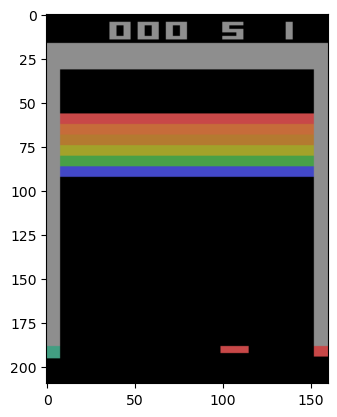

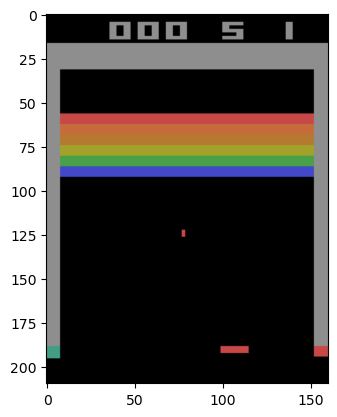

In [49]:

class AsyncVectorEnv(VectorEnv):
    """Vectorized environment that runs multiple environments in parallel. It
    uses `multiprocessing` processes, and pipes for communication.

    Parameters
    ----------
    env_fns : iterable of callable
        Functions that create the environments.

    observation_space : `gym.spaces.Space` instance, optional
        Observation space of a single environment. If `None`, then the
        observation space of the first environment is taken.

    action_space : `gym.spaces.Space` instance, optional
        Action space of a single environment. If `None`, then the action space
        of the first environment is taken.

    shared_memory : bool (default: `True`)
        If `True`, then the observations from the worker processes are
        communicated back through shared variables. This can improve the
        efficiency if the observations are large (e.g. images).

    copy : bool (default: `True`)
        If `True`, then the `reset` and `step` methods return a copy of the
        observations.

    context : str, optional
        Context for multiprocessing. If `None`, then the default context is used.
        Only available in Python 3.

    daemon : bool (default: `True`)
        If `True`, then subprocesses have `daemon` flag turned on; that is, they
        will quit if the head process quits. However, `daemon=True` prevents
        subprocesses to spawn children, so for some environments you may want
        to have it set to `False`

    worker : function, optional
        WARNING - advanced mode option! If set, then use that worker in a subprocess
        instead of a default one. Can be useful to override some inner vector env
        logic, for instance, how resets on done are handled. Provides high
        degree of flexibility and a high chance to shoot yourself in the foot; thus,
        if you are writing your own worker, it is recommended to start from the code
        for `_worker` (or `_worker_shared_memory`) method below, and add changes
    """

    def __init__(
        self,
        env_fns,
        observation_space=None,
        action_space=None,
        shared_memory=True,
        copy=True,
        context=None,
        daemon=True,
        worker=None,
    ):
        ctx = mp.get_context(context)
        self.env_fns = env_fns
        self.shared_memory = shared_memory
        self.copy = copy
        dummy_env = env_fns[0]()
        self.metadata = dummy_env.metadata

        if (observation_space is None) or (action_space is None):
            observation_space = observation_space or dummy_env.observation_space
            action_space = action_space or dummy_env.action_space
        dummy_env.close()
        del dummy_env
        super(AsyncVectorEnv, self).__init__(
            num_envs=len(env_fns),
            observation_space=observation_space,
            action_space=action_space,
        )

        if self.shared_memory:
            try:
                _obs_buffer = create_shared_memory(
                    self.single_observation_space, n=self.num_envs, ctx=ctx
                )
                self.observations = read_from_shared_memory(
                    _obs_buffer, self.single_observation_space, n=self.num_envs
                )
            except CustomSpaceError:
                raise ValueError(
                    "Using `shared_memory=True` in `AsyncVectorEnv` "
                    "is incompatible with non-standard Gym observation spaces "
                    "(i.e. custom spaces inheriting from `gym.Space`), and is "
                    "only compatible with default Gym spaces (e.g. `Box`, "
                    "`Tuple`, `Dict`) for batching. Set `shared_memory=False` "
                    "if you use custom observation spaces."
                )
        else:
            _obs_buffer = None
            self.observations = create_empty_array(
                self.single_observation_space, n=self.num_envs, fn=np.zeros
            )

        self.parent_pipes, self.processes = [], []
        self.error_queue = ctx.Queue()
        target = _worker_shared_memory if self.shared_memory else _worker
        target = worker or target
        with clear_mpi_env_vars():
            for idx, env_fn in enumerate(self.env_fns):
                parent_pipe, child_pipe = ctx.Pipe()
                process = ctx.Process(
                    target=target,
                    name="Worker<{0}>-{1}".format(type(self).__name__, idx),
                    args=(
                        idx,
                        CloudpickleWrapper(env_fn),
                        child_pipe,
                        parent_pipe,
                        _obs_buffer,
                        self.error_queue,
                    ),
                )

                self.parent_pipes.append(parent_pipe)
                self.processes.append(process)

                process.daemon = daemon
                process.start()
                child_pipe.close()

        self._state = AsyncState.DEFAULT
        self._check_observation_spaces()

    def seed(self, seeds=None):
        self._assert_is_running()
        if seeds is None:
            seeds = [None for _ in range(self.num_envs)]
        if isinstance(seeds, int):
            seeds = [seeds + i for i in range(self.num_envs)]
        assert len(seeds) == self.num_envs

        if self._state != AsyncState.DEFAULT:
            raise AlreadyPendingCallError(
                "Calling `seed` while waiting "
                "for a pending call to `{0}` to complete.".format(self._state.value),
                self._state.value,
            )

        for pipe, seed in zip(self.parent_pipes, seeds):
            pipe.send(("seed", seed))
        _, successes = zip(*[pipe.recv() for pipe in self.parent_pipes])
        self._raise_if_errors(successes)

    def reset_async(self):
        self._assert_is_running()
        if self._state != AsyncState.DEFAULT:
            raise AlreadyPendingCallError(
                "Calling `reset_async` while waiting "
                "for a pending call to `{0}` to complete".format(self._state.value),
                self._state.value,
            )

        for pipe in self.parent_pipes:
            pipe.send(("reset", None))
        self._state = AsyncState.WAITING_RESET

    def reset_wait(self, timeout=None):
        """
        Parameters
        ----------
        timeout : int or float, optional
            Number of seconds before the call to `reset_wait` times out. If
            `None`, the call to `reset_wait` never times out.

        Returns
        -------
        observations : sample from `observation_space`
            A batch of observations from the vectorized environment.
        """
        self._assert_is_running()
        if self._state != AsyncState.WAITING_RESET:
            raise NoAsyncCallError(
                "Calling `reset_wait` without any prior " "call to `reset_async`.",
                AsyncState.WAITING_RESET.value,
            )

        if not self._poll(timeout):
            self._state = AsyncState.DEFAULT
            raise mp.TimeoutError(
                "The call to `reset_wait` has timed out after "
                "{0} second{1}.".format(timeout, "s" if timeout > 1 else "")
            )

        results, successes = zip(*[pipe.recv() for pipe in self.parent_pipes])
        self._raise_if_errors(successes)
        self._state = AsyncState.DEFAULT

        if not self.shared_memory:
            self.observations = concatenate(
                results, self.observations, self.single_observation_space
            )

        return deepcopy(self.observations) if self.copy else self.observations

    def step_async(self, actions, inds=None):
        """
        Parameters
        ----------
        actions : iterable of samples from `action_space`
            List of actions.
        """
        self._assert_is_running()
        if self._state != AsyncState.DEFAULT:
            raise AlreadyPendingCallError(
                "Calling `step_async` while waiting "
                "for a pending call to `{0}` to complete.".format(self._state.value),
                self._state.value,
            )
        if inds is None:
            for pipe, action in zip(self.parent_pipes, actions):
                pipe.send(("step", action))
        else:
            for n, ind in enumerate(inds):
                self.parent_pipes[ind].send(("step", actions[n]))
        self.inds = inds
        self._state = AsyncState.WAITING_STEP

    def step_wait(self, timeout=None):
        """
        Parameters
        ----------
        timeout : int or float, optional
            Number of seconds before the call to `step_wait` times out. If
            `None`, the call to `step_wait` never times out.

        Returns
        -------
        observations : sample from `observation_space`
            A batch of observations from the vectorized environment.

        rewards : `np.ndarray` instance (dtype `np.float_`)
            A vector of rewards from the vectorized environment.

        dones : `np.ndarray` instance (dtype `np.bool_`)
            A vector whose entries indicate whether the episode has ended.

        infos : list of dict
            A list of auxiliary diagnostic information.
        """
        self._assert_is_running()
        if self._state != AsyncState.WAITING_STEP:
            raise NoAsyncCallError(
                "Calling `step_wait` without any prior call " "to `step_async`.",
                AsyncState.WAITING_STEP.value,
            )

        if not self._poll(timeout):
            self._state = AsyncState.DEFAULT
            raise mp.TimeoutError(
                "The call to `step_wait` has timed out after "
                "{0} second{1}.".format(timeout, "s" if timeout > 1 else "")
            )
        rec_pipes = self.parent_pipes if self.inds is None else [self.parent_pipes[i] for i in self.inds]
        results, successes = zip(*[pipe.recv() for pipe in rec_pipes])
        self._raise_if_errors(successes)
        self._state = AsyncState.DEFAULT
        observations_list, rewards, dones, infos = zip(*results)

        if not self.shared_memory:
            if self.inds is None:
                self.observations = concatenate(
                    observations_list, self.observations, self.single_observation_space
                )
                ret_observations = deepcopy(self.observations) if self.copy else self.observations
            else:
                for i in self.inds: self.observations[i] = observations_list[i]
                ret_observations = np.array([self.observations[i] for i in self.inds])
                if self.copy: 
                    ret_observations = deepcopy(ret_observations) 
        else:
            if self.inds is None:
                ret_observations = deepcopy(self.observations) if self.copy else self.observations
            else:
                ret_observations = np.array([self.observations[i] for i in self.inds])        
                if self.copy: 
                    ret_observations = deepcopy(ret_observations) 

        return (
            ret_observations,
            np.array(rewards),
            np.array(dones, dtype=np.bool_),
            infos,
        )

    def close_extras(self, timeout=None, terminate=False):
        """
        Parameters
        ----------
        timeout : int or float, optional
            Number of seconds before the call to `close` times out. If `None`,
            the call to `close` never times out. If the call to `close` times
            out, then all processes are terminated.

        terminate : bool (default: `False`)
            If `True`, then the `close` operation is forced and all processes
            are terminated.
        """
        timeout = 0 if terminate else timeout
        try:
            if self._state != AsyncState.DEFAULT:
                logger.warn(
                    "Calling `close` while waiting for a pending "
                    "call to `{0}` to complete.".format(self._state.value)
                )                
                function = getattr(self, "{0}_wait".format(self._state.value))
                function(timeout)
        except mp.TimeoutError:
            terminate = True

        if terminate:
            for process in self.processes:
                if process.is_alive():
                    process.terminate()
        else:
            for pipe in self.parent_pipes:
                if (pipe is not None) and (not pipe.closed):
                    pipe.send(("close", None))
            for pipe in self.parent_pipes:
                if (pipe is not None) and (not pipe.closed):
                    pipe.recv()

        for pipe in self.parent_pipes:
            if pipe is not None:
                pipe.close()
        for process in self.processes:
            process.join()

    def _poll(self, timeout=None):
        self._assert_is_running()
        if timeout is None:
            return True
        end_time = time.perf_counter() + timeout
        delta = None
        for pipe in self.parent_pipes:
            delta = max(end_time - time.perf_counter(), 0)
            if pipe is None:
                return False
            if pipe.closed or (not pipe.poll(delta)):
                return False
        return True

    def _check_observation_spaces(self):
        self._assert_is_running()
        for pipe in self.parent_pipes:
            pipe.send(("_check_observation_space", self.single_observation_space))
        same_spaces, successes = zip(*[pipe.recv() for pipe in self.parent_pipes])
        self._raise_if_errors(successes)
        if not all(same_spaces):
            raise RuntimeError(
                "Some environments have an observation space "
                "different from `{0}`. In order to batch observations, the "
                "observation spaces from all environments must be "
                "equal.".format(self.single_observation_space)
            )

    def _assert_is_running(self):
        if self.closed:
            raise ClosedEnvironmentError(
                "Trying to operate on `{0}`, after a "
                "call to `close()`.".format(type(self).__name__)
            )

    def _raise_if_errors(self, successes):
        if all(successes):
            return

        num_errors = self.num_envs - sum(successes)
        assert num_errors > 0
        for _ in range(num_errors):
            index, exctype, value = self.error_queue.get()
            logger.error(
                "Received the following error from Worker-{0}: "
                "{1}: {2}".format(index, exctype.__name__, value)
            )
            logger.error("Shutting down Worker-{0}.".format(index))
            self.parent_pipes[index].close()
            self.parent_pipes[index] = None

        logger.error("Raising the last exception back to the main process.")
        raise exctype(value)


def _worker(index, env_fn, pipe, parent_pipe, shared_memory, error_queue):
    assert shared_memory is None
    env = env_fn()
    parent_pipe.close()
    try:
        while True:
            command, data = pipe.recv()
            if command == "reset":
                observation = env.reset()
                pipe.send((observation, True))
            elif command == "step":
                observation, reward, done, info = env.step(data)
                if done:
                    observation = env.reset()
                pipe.send(((observation, reward, done, info), True))
            elif command == "seed":
                env.seed(data)
                pipe.send((None, True))
            elif command == "close":
                pipe.send((None, True))
                break
            elif command == "_check_observation_space":
                pipe.send((data == env.observation_space, True))
            else:
                raise RuntimeError(
                    "Received unknown command `{0}`. Must "
                    "be one of {`reset`, `step`, `seed`, `close`, "
                    "`_check_observation_space`}.".format(command)
                )
    except (KeyboardInterrupt, Exception):
        error_queue.put((index,) + sys.exc_info()[:2])
        pipe.send((None, False))
    finally:
        env.close()


def _worker_shared_memory(index, env_fn, pipe, parent_pipe, shared_memory, error_queue):
    assert shared_memory is not None
    env = env_fn()
    observation_space = env.observation_space
    parent_pipe.close()
    try:
        while True:
            command, data = pipe.recv()
            if command == "reset":
                observation = env.reset()
                write_to_shared_memory(
                    index, observation, shared_memory, observation_space
                )
                pipe.send((None, True))
            elif command == "step":
                observation, reward, done, info = env.step(data)
                if done:
                    observation = env.reset()
                write_to_shared_memory(
                    index, observation, shared_memory, observation_space
                )
                pipe.send(((None, reward, done, info), True))
            elif command == "seed":
                env.seed(data)
                pipe.send((None, True))
            elif command == "close":
                pipe.send((None, True))
                break
            elif command == "_check_observation_space":
                pipe.send((data == observation_space, True))
            else:
                raise RuntimeError(
                    "Received unknown command `{0}`. Must "
                    "be one of {`reset`, `step`, `seed`, `close`, "
                    "`_check_observation_space`}.".format(command)
                )
    except (KeyboardInterrupt, Exception):
        error_queue.put((index,) + sys.exc_info()[:2])
        pipe.send((None, False))
    finally:
        env.close()

env_n = 4
#env = gym.vector.AsyncVectorEnv([lambda: gym.make("cSokoban-v0") for _ in range(env_n)])
env = AsyncVectorEnv([lambda: gym.make("Breakout-v4") for _ in range(env_n)])
obs = env.reset()

fig, ax = plt.subplots()
ax.imshow(obs[2])

out = env.step([1,1], inds=[2,3])
print(out[0].shape)

fig, ax = plt.subplots()
ax.imshow(out[0][1])

In [33]:
class Node:
    def __init__(self, parent, action, logit, num_actions, discounting, rec_t):        
        
        self.action = F.one_hot(torch.tensor(action).long(), num_actions) # shape (1, num_actions)        
        self.r = torch.tensor([0.], dtype=torch.float32)    
        self.v = torch.tensor([0.], dtype=torch.float32)            
        self.logit = logit # shape (1,)        
        
        self.rollout_qs = []  # list of tensors of shape (1,)
        self.rollout_n = torch.tensor([0.], dtype=torch.float32)    
        self.parent = parent
        self.children = []
        self.encoded = None 
        
        self.num_actions = num_actions
        self.discounting = discounting
        self.rec_t = rec_t        
        
        self.visited = False

    def expanded(self):
        return len(self.children) > 0

    def expand(self, r, v, logits, encoded, override=False):
        """
        First time arriving a node and so we expand it
        r, v: tensor of shape (1,)
        logits: tensor of shape (num_actions,)
        """
        if not override: assert not self.expanded()
        if override:
            self.rollout_qs = [x - self.r + r for x in self.rollout_qs]
            self.rollout_qs[0] = v * self.discounting
        self.r = r
        self.v = v
        self.encoded = encoded
        for a in range(self.num_actions):
            if not override:
                child = self.children.append(Node(self, a, logits[[a]], 
                   self.num_actions, self.discounting, self.rec_t))
            else:
                self.children[a].logit = logits[[a]]        
            
    def visit(self):
        self.trail_r = torch.tensor([0.], dtype=torch.float32)    
        self.trail_discount = 1.
        self.propagate(self.r, self.v, not self.visited)        
        self.visited = True
        
    def propagate(self, r, v, new_rollout):
        self.trail_r = self.trail_r + self.trail_discount * r
        self.trail_discount = self.trail_discount * self.discounting
        self.rollout_q = self.trail_r + self.trail_discount * v
        if new_rollout:
            self.rollout_qs.append(self.rollout_q)
            self.rollout_n = self.rollout_n + 1
        if self.parent is not None: self.parent.propagate(r, v, new_rollout)
            
    def stat(self):
        assert self.expanded()
        self.child_logits = torch.concat([x.logit for x in self.children])        
        child_rollout_qs_mean = []
        child_rollout_qs_max = []
        for x in self.children:
            if len(x.rollout_qs) > 0:                
                q_mean = torch.mean(torch.cat(x.rollout_qs), dim=-1, keepdim=True)
                q_max = torch.max(torch.cat(x.rollout_qs), dim=-1, keepdim=True)[0]
            else:
                q_mean = torch.tensor([0.], dtype=torch.float32)    
                q_max = torch.tensor([0.], dtype=torch.float32)    
            child_rollout_qs_mean.append(q_mean)
            child_rollout_qs_max.append(q_max)
        self.child_rollout_qs_mean = torch.concat(child_rollout_qs_mean)
        self.child_rollout_qs_max = torch.concat(child_rollout_qs_max)
        
        self.child_rollout_ns = torch.tensor([x.rollout_n for x in self.children]).long()
        self.child_rollout_ns_enc = self.child_rollout_ns / self.rec_t       
            
        ret_list = ["action", "r", "v", "child_logits", "child_rollout_qs_mean",
                    "child_rollout_qs_max", "child_rollout_ns_enc"]
        self.ret_dict = {x: getattr(self, x) for x in ret_list}
        out = torch.concat(list(self.ret_dict.values()))        
        return out         

class ModelWrapper(gym.Wrapper):
    """Wrap the gym environment with a model; output for each 
    step is (out, reward, done, info), where out is a tuple 
    of (gym_env_out, model_out) that corresponds to underlying 
    environment frame and output from the model wrapper.
    """

    def __init__(self, env, flags, env_n):
        gym.Wrapper.__init__(self, env)
        
        self.env = env     
        self.rec_t = flags.rec_t        
        self.flex_t = flags.flex_t 
        self.flex_t_cost = flags.flex_t_cost         
        self.discounting = flags.discounting
        self.perfect_model = flags.perfect_model
        self.tree_carry = flags.tree_carry
        self.thres_carry = flags.thres_carry        
        self.thres_discounting = flags.thres_discounting
        self.num_actions = env.action_space.n
        self.env_n = env_n

        self.cur_node = None
        self.root_node = None
            
        if not self.flex_t:
            obs_n = 9 + self.num_actions * 10 + self.rec_t
        else:
            obs_n = 10 + self.num_actions * 11 
        
        self.observation_space = gym.spaces.Box(
          low=-np.inf, high=np.inf, shape=(env_n, obs_n, 1, 1), dtype=float)
        
        self.max_rollout_depth = torch.zeros(env_n, dtype=int)
        self.cur_t = torch.zeros(env_n, dtype=int)
        self.thres = None
        self.baseline_max_q = None
        self.baseline_mean_q = None
        self.root_max_q = None
        
    def step(self, action, model_net, model_state=None):  
        # action is in shape (1, env_n, 3) or (1, env_n, 4); 
        # which corresponds to real_action, im_action, reset, term
        if not self.flex_t:
            re_action, im_action, reset = action[:, :, 0], action[:, :, 1], action[:, :, 2]
            term = None
        else:
            re_action, im_action, reset, term = (action[:, :, 0], action[:, :, 1], 
                action[:, :, 2], action[:, :, 3])
            info = {}
            info["max_rollout_depth"] = self.max_rollout_depth
        imagine = (not self.flex_t and self.cur_t < self.rec_t - 1) or (
            self.flex_t and self.cur_t < self.rec_t - 1 and not term)



                     

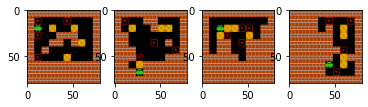

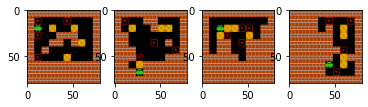

In [13]:
env_n = 4
flags = util.parse([])

env = gym.vector.make(flags.env, num_envs=env_n)
env.seed([i for i in range(env_n)])




actions = np.array([1, 0, 1, 2])

obs = env.reset()
fig, axes = plt.subplots(1,4)
for i in range(4):
    axes[i].imshow(obs[i])

fig, axes = plt.subplots(1,4)
for i in range(4):
    axes[i].imshow(obs[i])

In [21]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.actor_see_p = 0
flags.actor_drc = True
flags.rec_t = 5

env = Environment(flags)
model_net = ModelNet((3,80,80), 5, flags)
env_out, model_state = env.initial(model_net)
actor_net = ActorNet(env.model_out_shape, 5, flags)

nc = actor_net
print("actor network size: ", sum(p.numel() for p in nc.parameters()))
nc = model_net
print("model network size: ", sum(p.numel() for p in nc.parameters()))

a = torch.tensor([1,1,1]).long().unsqueeze(0).unsqueeze(0)
actor_state = actor_net.initial_state(1)

for n in range(5):
   env_out, model_state = env.step(a, model_net, model_state)
   actor_out, actor_state = actor_net(env_out, actor_state)

actor network size:  660158
model network size:  2352882


AttributeError: 'SokobanEnv' object has no attribute 'baseline_max_q'

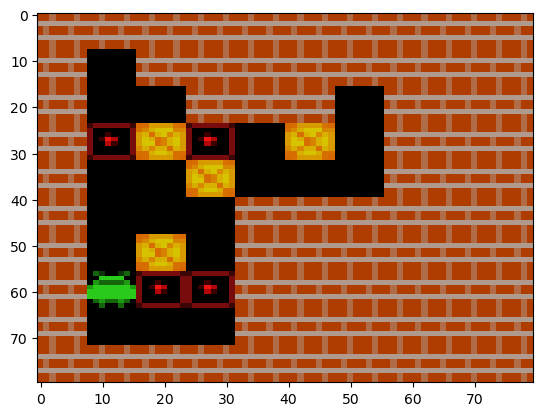

In [5]:
a = torch.tensor([4,2,0]).long().unsqueeze(0).unsqueeze(0)
env_out, model_state = env.step(a, model_net, model_state)
cur_t = env_out.cur_t
x = env_out.gym_env_out[0]
plot_gym_env_out(x)
print(env_out.cur_t, env_out.see_mask, env.env.baseline_max_q)
device = torch.device("cuda")
actor_net.to(device)
actor_state = util.tuple_map(actor_state, lambda x: x.to(device))
env_out = util.tuple_map(env_out, lambda x: x.to(device))

out, actor_state = actor_net(env_out, actor_state)
print([x.dtype for x in out[0] if x is not None])


In [19]:
k = 3
t = 4
n = 1
next_ind = np.array([3, np.nan, np.nan])

base_ind = 2 * n
base_ind_pri = t * base_ind

abs_flat_inds = np.array([6 + base_ind_pri, 5 + base_ind_pri])

# compute the correct index to update; if the indexes are across blocks,
# we have to carry the overflowing index to the next block

flat_inds = abs_flat_inds - base_ind_pri # get the relative index
mask = flat_inds > 0 
flat_inds = flat_inds[mask] 

flat_inds = flat_inds[:, np.newaxis] + np.arange(k) # flat_inds now stores uncarried indexes
flat_inds_block = flat_inds // (t * n) # block index of flat_inds
carry_mask = ~(flat_inds_block[:,[0]] == flat_inds_block).reshape(-1) 
# if first index block is not the same as the later index block, we need to carry it

flat_inds = flat_inds.reshape(-1)
flat_inds_block = flat_inds_block.reshape(-1)
carry_inds_block = next_ind[flat_inds_block[carry_mask]-1] - base_ind // n  # the correct index block

flat_inds = flat_inds.astype(float)
flat_inds[carry_mask] = flat_inds[carry_mask] + (-flat_inds_block[carry_mask] + carry_inds_block) * (t * n) 
mask = ~np.isnan(flat_inds)
flat_inds = flat_inds[mask].astype(int)
print(flat_inds_block)
print(carry_mask)
print(carry_inds_block)
print(flat_inds)

[1 1 2 1 1 1]
[False False  True False False False]
[nan]
[6 7 5 6 7]


In [ ]:

flags = util.parse([])
flags.model_batch_size = 2
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = False
flags.model_rnn = True
flags.model_unroll_length = 8
t = flags.model_unroll_length   
flags.model_k_step_return = 5
k = flags.model_k_step_return
flags.actor_parallel_n = 1
n = flags.actor_parallel_n  

flags.model_batch_mode = True

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),c), torch.full((t+k, n, 1),c+0.1))    
    state = (torch.full((n, 3),c+0.2), torch.full((n, 3),c+0.3))
    model_buffer.write(data, state, np.random.randint(10))

print(model_buffer.next_inds)
data, data_state, weights, abs_flat_inds, inds = model_buffer.read(1)
print(data.x[:, :, -1], data_state)

state = tuple(torch.zeros_like(x) for x in data_state)
priorities = torch.zeros(len(abs_flat_inds))

model_buffer.update_priority(abs_flat_inds, priorities, state)



In [77]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.model_rnn = True

model_net_1 = ModelNet((3,80,80), 5, flags)
nc = model_net_1
print("network size: ", sum(p.numel() for p in nc.parameters()))

flags.model_rnn = False
model_net_2 = ModelNet((3,80,80), 5, flags)
nc = model_net_2
print("network size: ", sum(p.numel() for p in nc.parameters()))

network size:  841223
network size:  2352882


In [79]:
tran = {"conv1":  "output_rvpi.conv1",
        "conv2":  "output_rvpi.conv2",
        "policy": "output_rvpi.fc_logits",
        "baseline": "output_rvpi.fc_v",
        "r": "output_rvpi.fc_r",
        "frame_conv.0":  "output_rvpi.conv1",
        "frame_conv.2":  "output_rvpi.conv2",}

state_dict = {}
for k in model_net_1.state_dict().keys():
    #print(k)
    if k not in model_net_2.state_dict().keys():
        for p, q in tran.items():
            if k[:len(p)+1] == p+".":
                out = q + k[len(p):]
                break
    else:
        out = k
    state_dict[k] = model_net_2.state_dict()[out]

model_net_1.load_state_dict(state_dict)
model_net_1.train(False)
model_net_2.train(False)

x = torch.rand(4, 3, 80, 80) * 2555
actions = torch.zeros(1, 4, dtype=torch.long)
done = torch.zeros(1, 4, dtype=torch.bool)

state = model_net_1.init_state(4)
vs, logits, states = model_net_1(x=x.unsqueeze(0), actions=actions, done=done, state=state)
print(logits)

rs, vs, logits, encodeds = model_net_2(x=x, actions=actions)
print(logits)

tensor([[[ 0.0005,  0.0253,  0.0640,  0.0987, -0.0419],
         [ 0.0010,  0.0284,  0.0646,  0.0968, -0.0359],
         [ 0.0019,  0.0287,  0.0614,  0.0948, -0.0363],
         [ 0.0028,  0.0284,  0.0636,  0.0960, -0.0396]]],
       grad_fn=<ViewBackward0>)
tensor([[[ 0.0005,  0.0253,  0.0640,  0.0987, -0.0419],
         [ 0.0010,  0.0284,  0.0646,  0.0968, -0.0359],
         [ 0.0019,  0.0287,  0.0614,  0.0948, -0.0363],
         [ 0.0028,  0.0284,  0.0636,  0.0960, -0.0396]]],
       grad_fn=<CatBackward0>)
